In [38]:
import pandas as pd
import numpy as np

In [88]:
DATASET_PATH='./bmw.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


Датасет содержит информацию о машинах марки BMW, их основных характеристиках и стоимости каждой машины. В датасете 10781 запись. 8 предположительно независимых показателей:
 * <b>model</b> - модель, 
 * <b>year</b> - год выпуска, 
 * <b>transmission</b> - коробка передач, 
 * <b>mileage</b> - пробег, 
 * <b>fuelType</b> - тип топлива, 
 * <b>tax</b> - налог?, 
 * <b>mpg</b> - расход топлива на единицу пробега, 
 * <b>engineSize</b> - мощность двигателя <br>
 
 И один результирующий - <b>price</b> (цена).

## Проверка на целостность данных и предварительная обработка

Проверим датасет на целостность данных:

In [40]:
len(df)

10781

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


В датасете 10781 запись и для каждого признака соответствующее количество значений. Пропусков нет.

Поработаем с категориальными переменными. У нас их 3: model, transmission, fuelType. Признак model закодируем средней ценой в разрезе моделей, a transmission и fuelType преобразуем в dummies.

### Кодирование переменной model

In [89]:
def code_mean(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].mean()))

df['model_mean_price'] = code_mean(df, 'model', 'price')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,model_mean_price
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,22537.428030
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,24354.370370
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,22537.428030
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,15821.670391
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,36934.320755
...,...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0,27758.310345
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0,22537.428030
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0,19880.857962
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0,15821.670391


### Кодирование переменной transmission

In [90]:
dummy_transmission = pd.get_dummies(df['transmission'], prefix='transm_')
dummy_transmission.head()

,transm__Automatic,transm__Manual,transm__Semi-Auto
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [91]:
df = pd.merge(
    left=df,
    right=dummy_transmission,
    left_index=True,
    right_index=True,
)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,model_mean_price,transm__Automatic,transm__Manual,transm__Semi-Auto
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,22537.428030,1,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,24354.370370,1,0,0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,22537.428030,1,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,15821.670391,1,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,36934.320755,1,0,0


### Кодирование переменной fuelType

In [93]:
dummy_fuel = pd.get_dummies(df['fuelType'], prefix='fuel_')
dummy_fuel.head()

,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [94]:
df = pd.merge(
    left=df,
    right=dummy_fuel,
    left_index=True,
    right_index=True,
)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,model_mean_price,transm__Automatic,transm__Manual,transm__Semi-Auto,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,22537.428030,1,0,0,1,0,0,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,24354.370370,1,0,0,0,0,0,0,1
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,22537.428030,1,0,0,1,0,0,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,15821.670391,1,0,0,1,0,0,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,36934.320755,1,0,0,1,0,0,0,0


In [188]:
df = df.drop(['model', 'transmission', 'fuelType'], axis=1)
df.head()

,year,price,mileage,tax,mpg,engineSize,model_mean_price,transm__Automatic,transm__Manual,transm__Semi-Auto,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol
0,2014,11200,67068,125,57.6,2.0,22537.428030,1,0,0,1,0,0,0,0
1,2018,27000,14827,145,42.8,2.0,24354.370370,1,0,0,0,0,0,0,1
2,2016,16000,62794,160,51.4,3.0,22537.428030,1,0,0,1,0,0,0,0
3,2017,12750,26676,145,72.4,1.5,15821.670391,1,0,0,1,0,0,0,0
4,2014,14500,39554,160,50.4,3.0,36934.320755,1,0,0,1,0,0,0,0


<font color='red'><b> Вопрос 1: Нужно ли, после завершения кодирования категориальных переменных, удалять первоначальные столбцы (те, что со строковыми значениями) из рабочей базы? (чтобы информация не дублировалась и сэкономить место? Или они еще могут где-то пригодиться?) 

### Целевая переменная

#### Проверка на нормальность

In [96]:
df.price.describe()

count     10781.000000
mean      22733.408867
std       11415.528189
min        1200.000000
25%       14950.000000
50%       20462.000000
75%       27940.000000
max      123456.000000
Name: price, dtype: float64

In [45]:
mean = round(df['price'].mean(), 2)
median = df['price'].median()
mode = df['price'].mode()[0]
print(f'mean - {mean}, median - {median}, mode - {mode}')

mean - 22733.41, median - 20462.0, mode - 20980


<font color='red'><b> Вопрос 2: Правильно ли я понимаю, что раз среднее, медиана и мода примерно равны - то распределение можно считать близким к нормальному?

#### Визуальная проверка на нормальность:

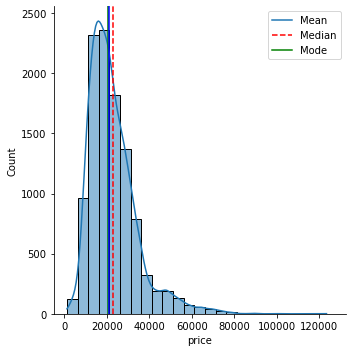

In [46]:
price = df['price']
sns.displot(price, binwidth=5000, kde=True)
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')
plt.axvline(mode, color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median,'Mode':mode})
plt.show()

<font color='red'><b> Но с другой стороны - у графика правый хвост значительно длинее. И средняя ведь должна по центру проходить, да? Я что-то должна сделать? Как-то привести их к нормальному распределению? Или таким несоответствием можно пренебречь?

С той же целью построим qq график:

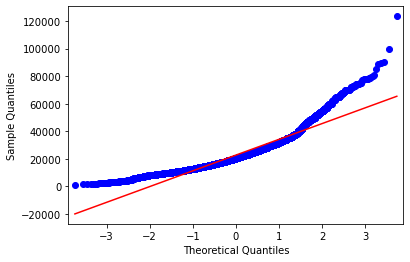

In [100]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df['price'], line='s')
plt.show()

<font color='red'><b> Не идеально, но ведь и не ужас-ужас? Или все-таки надо было что-то сделать?

#### Статистическая проверка на нормальность:

#### Тест Шапиро-Вилка

In [105]:
from scipy.stats import shapiro
stat, p = shapiro(df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.890, p=0.000
Sample does not look Gaussian (reject H0)


<font color='red'><b> Я так поняла, что тест Шапиро-Вилка лучше применять для датасета с набором наблюдей не более 5000. У меня в датасете более 10000 записей, поэтому мне этот тест не очень подходит. Правильно?

#### Тест д'Агостино на K ^ 2

In [106]:
from scipy.stats import normaltest
stat, p = normaltest(df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=3408.667, p=0.000
Sample does not look Gaussian (reject H0)


#### Тест Андерсона-Дарлинга

In [107]:
from scipy.stats import anderson
result = anderson(df['price'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 256.941
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


<b> В общем, как ни крути, распределение цены не является нормальным. Видимо, надо что-то делать. Погуглим.

Ну я нашла, что для стандартизации (приведению данных к нормальному распределению) можно взять натуральные логарифм. Но когда я сделала это для переменной 'price', получившиеся данные проверку на нормальное распределение не прошли.

<font color = 'red'> <b> Потом я нашла, что для стандартизации данных в Scikit-learn есть класс StandardScaler. Но когда я пытаюсь стандартизировать только переменную 'price' - то для нее у меня выдаются только нули. Почему? Обязательно стандартизировать всю базу данных?

In [205]:
df_std=StandardScaler().fit_transform(df)
df_std[0], df_std[1]

(array([-1.31078245, -1.0103732 ,  1.65344721, -0.10896272,  0.038326  ,
        -0.30391088, -0.02449798,  1.41588771, -0.55331238, -0.87352258,
         0.73090706, -0.01668367, -0.16860302, -0.0578826 , -0.68118582]),
 array([ 0.39212116,  0.37377062, -0.42438849,  0.21619875, -0.43398169,
        -0.30391088,  0.20262329,  1.41588771, -0.55331238, -0.87352258,
        -1.368163  , -0.01668367, -0.16860302, -0.0578826 ,  1.46802821]))

In [214]:
price_std = [row[0] for row in df_std]
df['price_std'] = price_std
df.head()

,year,price,mileage,tax,mpg,engineSize,model_mean_price,transm__Automatic,transm__Manual,transm__Semi-Auto,fuel__Diesel,fuel__Electric,fuel__Hybrid,fuel__Other,fuel__Petrol,price_std
0,2014,11200,67068,125,57.6,2.0,22537.428030,1,0,0,1,0,0,0,0,-1.310782
1,2018,27000,14827,145,42.8,2.0,24354.370370,1,0,0,0,0,0,0,1,0.392121
2,2016,16000,62794,160,51.4,3.0,22537.428030,1,0,0,1,0,0,0,0,-0.459331
3,2017,12750,26676,145,72.4,1.5,15821.670391,1,0,0,1,0,0,0,0,-0.033605
4,2014,14500,39554,160,50.4,3.0,36934.320755,1,0,0,1,0,0,0,0,-1.310782


Проверим, что у нас получилось:

#### Тест д'Агостино на K ^ 2

In [215]:
from scipy.stats import normaltest
stat, p = normaltest(df['price_std'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=4330.560, p=0.000
Sample does not look Gaussian (reject H0)


#### Тест Андерсона-Дарлинга

In [216]:
from scipy.stats import anderson
result = anderson(df['price_std'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 366.795
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


Оценим влияние количественных показателей на цену:

### Независимые признаки

Преобразуем категориальные признаки:

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

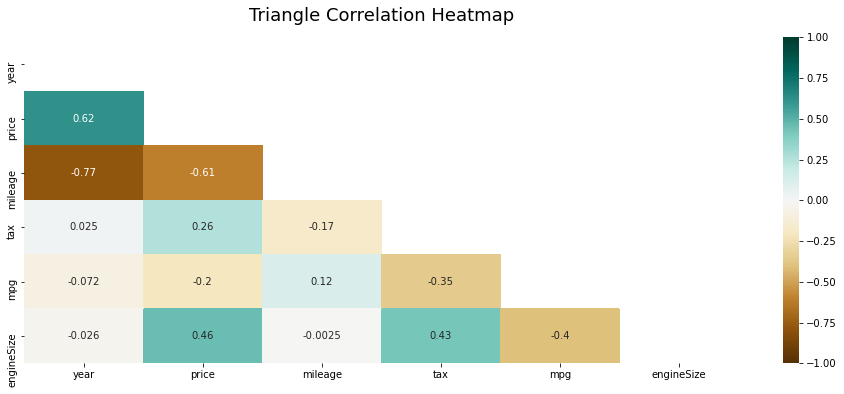

In [48]:
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, mask = mask, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

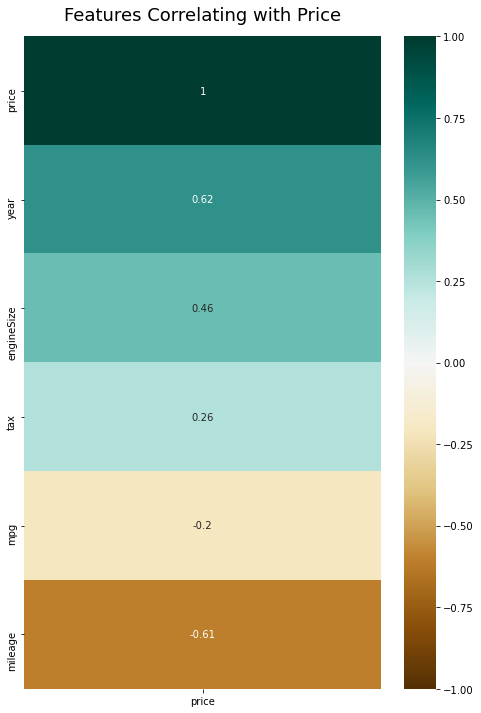

In [49]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

Из тепловой диаграммы мы видим, что на цену значимое влияние оказывают:
1. Год выпуска
2. Размер двигателя

## Применение коэффициента корреляции

Рассмотрим применение коэффициента корреляции на примере анализа зависимости цены от года выпуска машины в разрезе моделей.

In [50]:
model_list = np.unique(df['model'])
model_list

array([' 1 Series', ' 2 Series', ' 3 Series', ' 4 Series', ' 5 Series',
       ' 6 Series', ' 7 Series', ' 8 Series', ' M2', ' M3', ' M4', ' M5',
       ' M6', ' X1', ' X2', ' X3', ' X4', ' X5', ' X6', ' X7', ' Z3',
       ' Z4', ' i3', ' i8'], dtype=object)

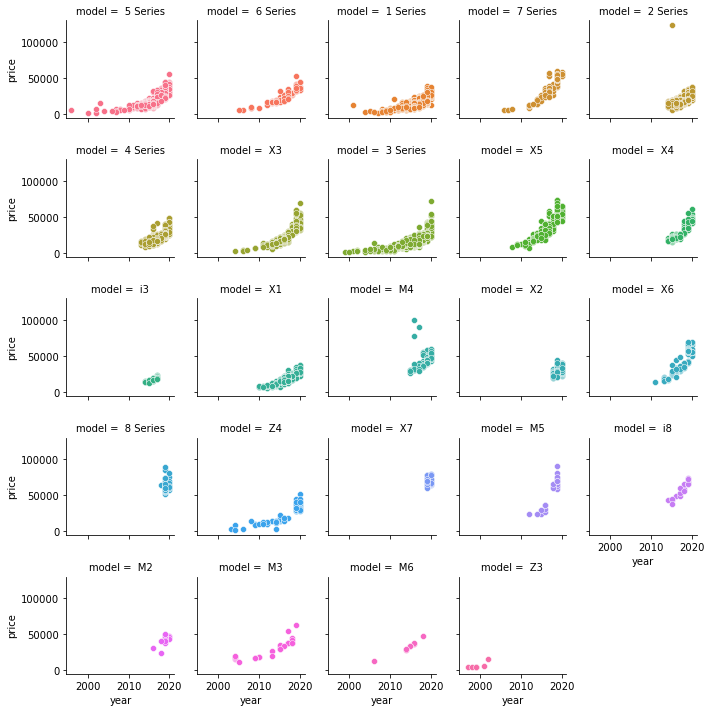

In [51]:
grid = sns.FacetGrid(df, col="model", hue="model", col_wrap=5, height=2)
grid.map(sns.scatterplot, "year", "price")

За исключением моделей, которые выпускались ограниченное количество лет, мы видим четкую взаимосвязь между годом выпуска машины и ее ценой. Но при этом видно, что для некоторых моделей сила этой связи сильно отличается. Посчитаем коэффициенты корреляции между ценой и годом выпуска для каждой из моделей и сравним их между собой.

<b>Коэффициент корреляции (r)</b> характеризует величину отражающую степень взаимосвязи двух переменных между собой. Он может варьировать в пределах от -1 (отрицательная корреляция) до +1 (положительная корреляция). Если коэффициент корреляции равен 0 то, это говорит об отсутствии корреляционных связей между переменными. Причем если коэффициент корреляции ближе к 1 (или -1) то говориться о сильной корреляции, а если ближе к 0, то о слабой.

In [52]:
corr = []

for item in model_list:
    model = df[['year', 'price', 'model']].loc[(df['model'] == item)]
    corr.append(model['year'].corr(model['price']))
    

corr_df = pd.DataFrame(zip(model_list, corr), columns=['model', 'correlation'])
corr_df.sort_values('correlation')

,model,correlation
7,8 Series,0.064910
19,X7,0.199610
14,X2,0.431391
10,M4,0.486171
8,M2,0.631101
1,2 Series,0.671495
0,1 Series,0.755664
20,Z3,0.794279
22,i3,0.800488
2,3 Series,0.808115


<b>Практическая польза:</b> Я пока еще не очень умею строить модели прогнозирования. Поэтому, возможно, напишу чушь. Но, наверное, если бы мне нужно было бы спрогнозировать цену для списка машин, я бы объединила модели машин в группы по близким значениям коэффициента корреляции и строила бы различные модели прогнозирования для различных групп. Так, например, для группы с очень высоким коэффициентом корреляции, я бы, наверное, прогнозировала только на основании этих данных. А для групп с низкими коэффциентами корреляции - искала бы другие влияющие параметры. Или как-то корректировала модель прогнозирования. <font color='red'><b>Так?

## Оценка гипотезы

Поэкспериментируем с оценкой гипотизы на примере выявления взаимосвязи между типом коробки передач и ценой на автомобиль.

In [53]:
transmission_list = np.unique(df['transmission'])
transmission_list

array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)

In [54]:
transmission_mean = []
transmission_median = []
transmission_mode = []

for item in transmission_list:
    transmission = df[['year', 'price', 'transmission']].loc[(df['transmission'] == item)]
    transmission_mean.append(round(transmission['price'].mean(), 2))
    transmission_median.append(transmission['price'].median())
    transmission_mode.append(transmission['price'].mode()[0])

transmission_mean, transmission_median, transmission_mode
transmission_df = pd.DataFrame(zip(transmission_list, transmission_mean, transmission_median, transmission_mode), \
                               columns=['transmission', 'mean', 'median', 'mode'])
transmission_df

,transmission,mean,median,mode
0,Automatic,22419.02,19490.0,15000
1,Manual,14637.45,13500.0,20980
2,Semi-Auto,27359.75,24990.0,29995


In [55]:
ymean = transmission_df['mean']
ymedian = transmission_df['median']
ymode = transmission_df['mode']
xdata = transmission_df['transmission']

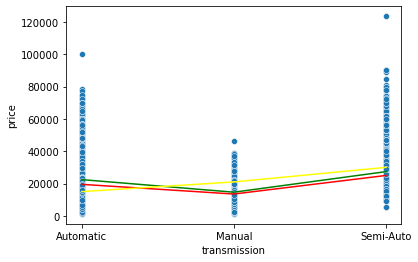

In [56]:
sns.scatterplot(data = df, x = "transmission", y = "price")
plt.plot(xdata, ymean, color='green')
plt.plot(xdata, ymedian, color='red')
plt.plot(xdata, ymode, color='yellow')
plt.show()

В принципе график ни о чем. Есть пара выбросов на автомате и полуавтомате. Максимальная цена ниже всех на ручной коробке, выше всех почему-то на полуавтомате. И все показатели (средняя, медиана и мода) почем-то выше всех на полуавтомате. В общем ничего не понятно.

Я так понимаю, что для проверки гипотезы нам надо создать три выборки и для начала проверить в них распределение цены:

In [57]:
automatic_df = df[['year', 'price', 'transmission']].loc[(df['transmission'] == 'Automatic')]
manual_df = df[['year', 'price', 'transmission']].loc[(df['transmission'] == 'Manual')]
semi_df = df[['year', 'price', 'transmission']].loc[(df['transmission'] == 'Semi-Auto')]

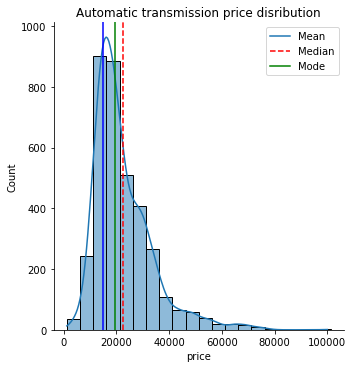

In [58]:
price_automatic = automatic_df['price']
sns.displot(price_automatic, binwidth=5000, kde=True)
plt.axvline(ymean[0], color='r', linestyle='--')
plt.axvline(ymedian[0], color='g', linestyle='-')
plt.axvline(ymode[0], color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median,'Mode':mode})
plt.title('Automatic transmission price disribution')
plt.show()

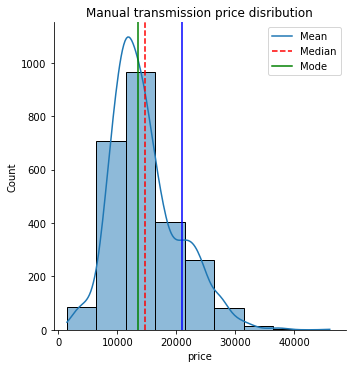

In [59]:
price_manual = manual_df['price']
sns.displot(price_manual, binwidth=5000, kde=True)
plt.axvline(ymean[1], color='r', linestyle='--')
plt.axvline(ymedian[1], color='g', linestyle='-')
plt.axvline(ymode[1], color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median,'Mode':mode})
plt.title('Manual transmission price disribution')
plt.show()

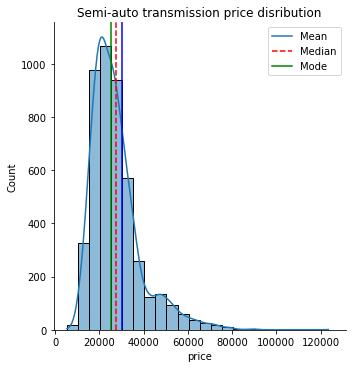

In [60]:
price_semi = semi_df['price']
sns.displot(price_semi, binwidth=5000, kde=True)
plt.axvline(ymean[2], color='r', linestyle='--')
plt.axvline(ymedian[2], color='g', linestyle='-')
plt.axvline(ymode[2], color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median,'Mode':mode})
plt.title('Semi-auto transmission price disribution')
plt.show()

<font color='red'><b> Я не понимаю. Все три графика далеки от нормального распределения. Так ведь? То есть я не могу проверять гипотезу так, как мы это делали на уроках? Я должна как-то привести данные к нормальному распределению? Или есть способы проверки гипотез на ненормированных данных? Я пока сделаю, как мы делали на уроке. Но подозреваю, что это не правильно.

In [61]:
from scipy import stats
stats.f_oneway(automatic_df['price'], manual_df['price'], semi_df['price'])

F_onewayResult(statistic=1257.9084939644226, pvalue=0.0)

<font color='red'><b> У меня фигня получилась? pvalue же не может нулю равнять?

Но если вдруг не фигня, то, что получается, что со 100% достоверностью мы можем утверждать, что цена зависит от вида трансмиссии?

Я, конечно понимаю, что выбор гипотезы у меня очень номинальный. Нельзя было брать всю кучу данных и поделить их только по признаку вида трансмиссии. Мы уже ранее выявили для большей части моделей очень сильную зависимость цены от года выпуска. Поэтому не учитывать данный момент при создании выборки, с точки зрения корректности выводов, было не правильно. Но я не очень поняла, как можно было бы правильно сделать выборки. (вариант взять конкретный год я не рассматривала - во-первых, не факт что в этом году выпускались машины со всеми тремя видами трансмиссий, во-вторых, как видно из последующего анализа взаимосвязи цены и трансмиссии, который я делаю в разрезе моделей - видна (и логична) хронологическая последовательность присутствия трансмиссий на рынке - в начале выпускали машины с ручной коробкой, потом полуавтомат, потом автомат. А цена, в нашей выборке тем ниже, чем старше машина. То есть все равно выводы не учтут влияния фактора времени). Как правильно было сделать выборки, чтобы проверить гипотезу о влиянии какого-то фактора?

Все-таки покопаемся еще во взаимосвязи цены и трансмиссии и попробуем увидеть что-нибудь анализируя эти показатели в разрезе моделей.

## Однофакторный дисперсионный анализ

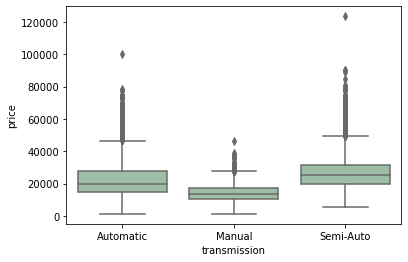

In [62]:
ax = sns.boxplot(x='transmission', y='price', data=df, color='#99c2a2')
#ax = sns.swarmplot(x="transmission", y="price", data=df, color='#7d0013')
plt.show()

In [63]:
fvalue, pvalue = stats.f_oneway(automatic_df['price'], manual_df['price'], semi_df['price'])
print(fvalue, pvalue)
# 1257.9084939644226 0.0

1257.9084939644226 0.0


In [64]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('price ~ C(transmission)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(transmission),2.658521e+11,2.0,1257.908494,0.0
Residual,1.138936e+12,10778.0,NaN,NaN


In [65]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df, res_var='price', anova_model='price ~ C(transmission)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(transmission),2.0,2.658521e+11,1.329261e+11,1257.908494,0.0
Residual,10778.0,1.138936e+12,1.056723e+08,NaN,NaN


In [66]:
res = stat()
res.tukey_hsd(df=df, res_var='price', xfac_var='transmission', anova_model='price ~ C(transmission)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Automatic,Manual,7781.572841,7155.804489,8407.341193,41.222322,0.001
1,Automatic,Semi-Auto,4940.723995,4405.694345,5475.753646,30.611979,0.001
2,Manual,Semi-Auto,12722.296836,12127.149842,13317.443831,70.863066,0.001


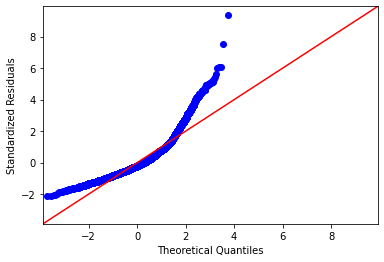

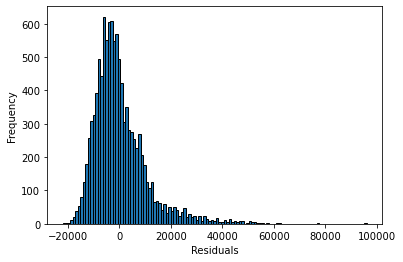

In [67]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [68]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8790550231933594 0.0


D:\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [69]:
import scipy.stats as stats
w, pvalue = stats.bartlett(automatic_df['price'], manual_df['price'], semi_df['price'])
print(w, pvalue)

1377.2776665580182 8.471390130344297e-300


In [70]:
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df, res_var='price', xfac_var='transmission')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),1377.2777
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


In [71]:
res = stat()
res.levene(df=df, res_var='price', xfac_var='transmission')
res.levene_summary

,Parameter,Value
0,Test statistics (W),217.4794
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


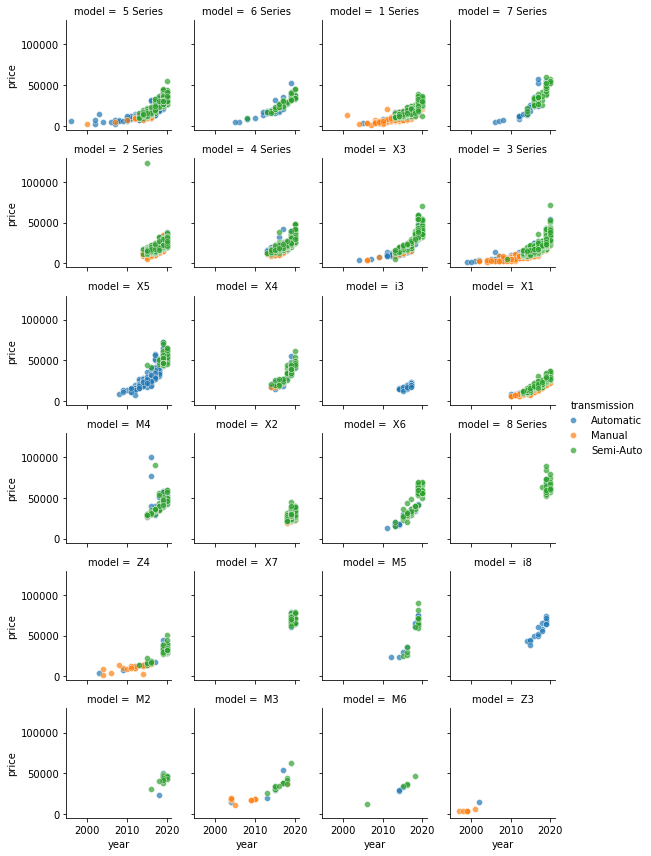

In [72]:
g = sns.FacetGrid(df, col="model", hue="transmission", col_wrap=4, height=2)
g.map(sns.scatterplot, "year", "price", alpha=.7)
g.add_legend()

Интуитивно кажется, что цена для автоматической коробки передач должна быть самой высокой, для полуавтомата - меньше автоматической, но выше ручной, а для ручной - самая низкая. Но из диаграмм выше я не вижу подтверждения этому выводу. Скорее видна трансформация коробки передач от ручной к автоматической (через полуавтомат) во времени.

## Двухфакторный дисперсионный анализ

Проведем двухфакторный дисперсионный анализ и оценим влияние модели и типа двигателя на цену.

<AxesSubplot:xlabel='model', ylabel='price'>

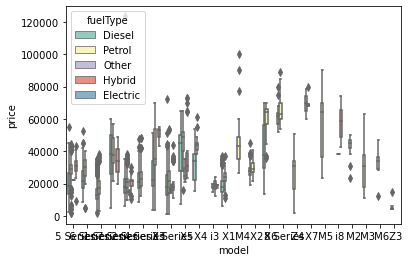

In [73]:
sns.boxplot(x="model", y="price", hue="fuelType", data=df, palette="Set3") 

In [74]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('price ~ C(model) + C(fuelType) + C(model):C(fuelType)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

D:\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 92, but rank is 36
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,2.230170e+11,1.0,3642.852644,0.000000e+00
C(model),5.499923e+11,23.0,390.600133,0.000000e+00
C(fuelType),1.108431e+10,4.0,45.263914,9.261406e-38
C(model):C(fuelType),4.975784e+11,92.0,88.344044,0.000000e+00
Residual,6.568340e+11,10729.0,NaN,NaN


In [75]:
res = stat()
res.anova_stat(df=df, res_var='price', anova_model='price~C(model)+C(fuelType)+C(model):C(fuelType)')
res.anova_summary

D:\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 13
  warnings.warn('covariance of constraints does not have full '
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  warnings.warn('covariance of constraints does not have full '
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 92, but rank is 36
  warnings.warn('covariance of constraints does not have full '


,df,sum_sq,mean_sq,F,PR(>F)
C(model),23.0,-9.102157e+11,-3.957460e+10,-6.464279e+02,1.0
C(fuelType),4.0,3.304412e+01,8.261030e+00,1.349391e-07,1.0
C(model):C(fuelType),92.0,4.975784e+11,5.408460e+09,8.834404e+01,0.0
Residual,10729.0,6.568340e+11,6.122043e+07,NaN,NaN


ValueError: Must be a color for each trace level

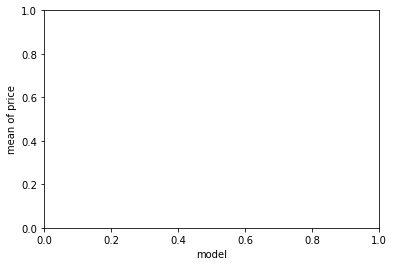

In [76]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=df['model'], trace=df['fuelType'], response=df['price'], colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()

In [ ]:
res = stat()
res.tukey_hsd(df=df, res_var='price', xfac_var='model', anova_model='price~C(model)+C(fuelType)+C(model):C(fuelType)')
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='price', xfac_var='fuelType', anova_model='price ~ C(model) + C(fuelType) + C(model):C(fuelType)')
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='price', xfac_var=['model','fuelType'], anova_model='price ~ C(model) + C(fuelType) + C(model):C(fuelType)')
res.tukey_summary.head()

In [ ]:
sns.barplot(x="year", y="price", data=df)

In [ ]:
df.value_counts()